In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

### Example of a very naive recommender system

Here, we explore a simple recommender based on friendly borrowing from [here](https://www.jillcates.com/pydata-workshop/html/tutorial.html) where also some variations and more efficient implementations are discussed.

As far as I understand recommender lingo this is an example of a collaborative filtering approach. Additionally it

 * is memory-based, i.e., similarity of users or items is computed from the user-item-interaction matrix to make predictions, not from a trained model. For instance, two items are similar if they have been similarly rated by many users. One problem with this approach is bad scaling for large datasets. Scaling can be improved using low rank matrix factorization (see blog post).

 * Alternatively, model-based approaches train a ML model based on the user-item-matrix, allowing for much better scalability. This is not explored here.

 * is item-based, i.e., recommendations are based on a given item (e.g., one that the user already likes) and then finding and recommending similar items. 
 
 * Alternatively, one could identify similar users, and then recommend something that those users like. This is called user-based cf and not explored here. 

In [2]:
# import transactions and article data
df_trans = pd.read_csv('data/transactions_train.csv')
df_art = pd.read_csv('data/articles.csv')

In [3]:
# reduce data, WARNING: more than 100k samples will take ages!
df = df_trans.sample(100000, random_state=42)
# create new column filled with ones
df['rating'] = df['customer_id'].apply(lambda s: 1)
# now have rating be the number of times a customer bought an item
df = df.groupby(['customer_id', 'article_id']).sum()
df = df.drop(['price', 'sales_channel_id'], axis=1).reset_index()
# make sure ratings lie between 0 and 5 (very naive method)
df['rating'] = df.rating.apply(lambda r: min(r, 5))

In [4]:
df.head()

,customer_id,article_id,rating
0,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,399061015,1
1,00007d2de826758b65a93dd24ce629ed66842531df6699...,721257001,1
2,0000f1c71aafe5963c3d195cf273f7bfd50bbf17761c91...,612075001,1
3,0001ab2ebc1bb9a21d135e2fefdb11f12bee5c74ab2984...,742947001,1
4,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,756582001,1


In [5]:
# create user-item-interaction matrix Y
# rows represent users, columns represent items
# note: users with no transactions and items never sold are not included
m = df.customer_id.nunique()
n = df.article_id.nunique()

# map between customer/article id and associated index
user_mapper = dict(zip(np.unique(df.customer_id), list(range(m))))
item_mapper = dict(zip(np.unique(df.article_id), list(range(n))))

user_inv_mapper = dict(zip(list(range(m)), np.unique(df.customer_id)))
item_inv_mapper = dict(zip(list(range(n)), np.unique(df.article_id)))

user_index = [user_mapper[i] for i in df.customer_id]
item_index = [item_mapper[i] for i in df.article_id]

# create sparse matrix
Y = csr_matrix((df.rating, (user_index, item_index)), shape=(m,n))


In [6]:
# check sparsity ratio
n_total = Y.shape[0]*Y.shape[1]
n_ratings = Y.nnz
sparsity = n_ratings/n_total
print('Matrix sparsity: ', round(sparsity*100, 2))

Matrix sparsity:  0.0


In [7]:
# mean normalization
n_ratings_per_item = Y.getnnz(axis=0)
sum_ratings_per_item = Y.sum(axis=0)
mean_rating_per_item = sum_ratings_per_item/n_ratings_per_item
# shape into matrix
Y_mean_item = np.tile(mean_rating_per_item, (Y.shape[0],1))
Y_norm = Y - csr_matrix(Y_mean_item)

In [ ]:
def find_similar_items(article_id, Y, item_mapper, item_inv_mapper, k=12, metric='cosine'):
    Y = Y.T
    neighbour_ids = []

    item_ind = item_mapper[article_id]
    item_vec = Y[item_ind]
    if isinstance(item_vec, (np.ndarray)):
        item_vec = item_vec.reshape(1, -1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric=metric)
    kNN.fit(Y)
    neighbour = kNN.kneighbors(item_vec, return_distance=False)
    for i in range(0,k+1):
        n = neighbour.item(i)
        neighbour_ids.append(item_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
# pick any article
article_id = df.iloc[400].article_id
article_name = df_art.query('article_id == @article_id').prod_name.values[0]
print(article_name)

Leia Dress


In [ ]:
# predict similar items based on user interactions
similar_items = find_similar_items(article_id, Y_norm, item_mapper, item_inv_mapper)

In [ ]:
item_names = dict(zip(df_art.article_id, df_art.prod_name))

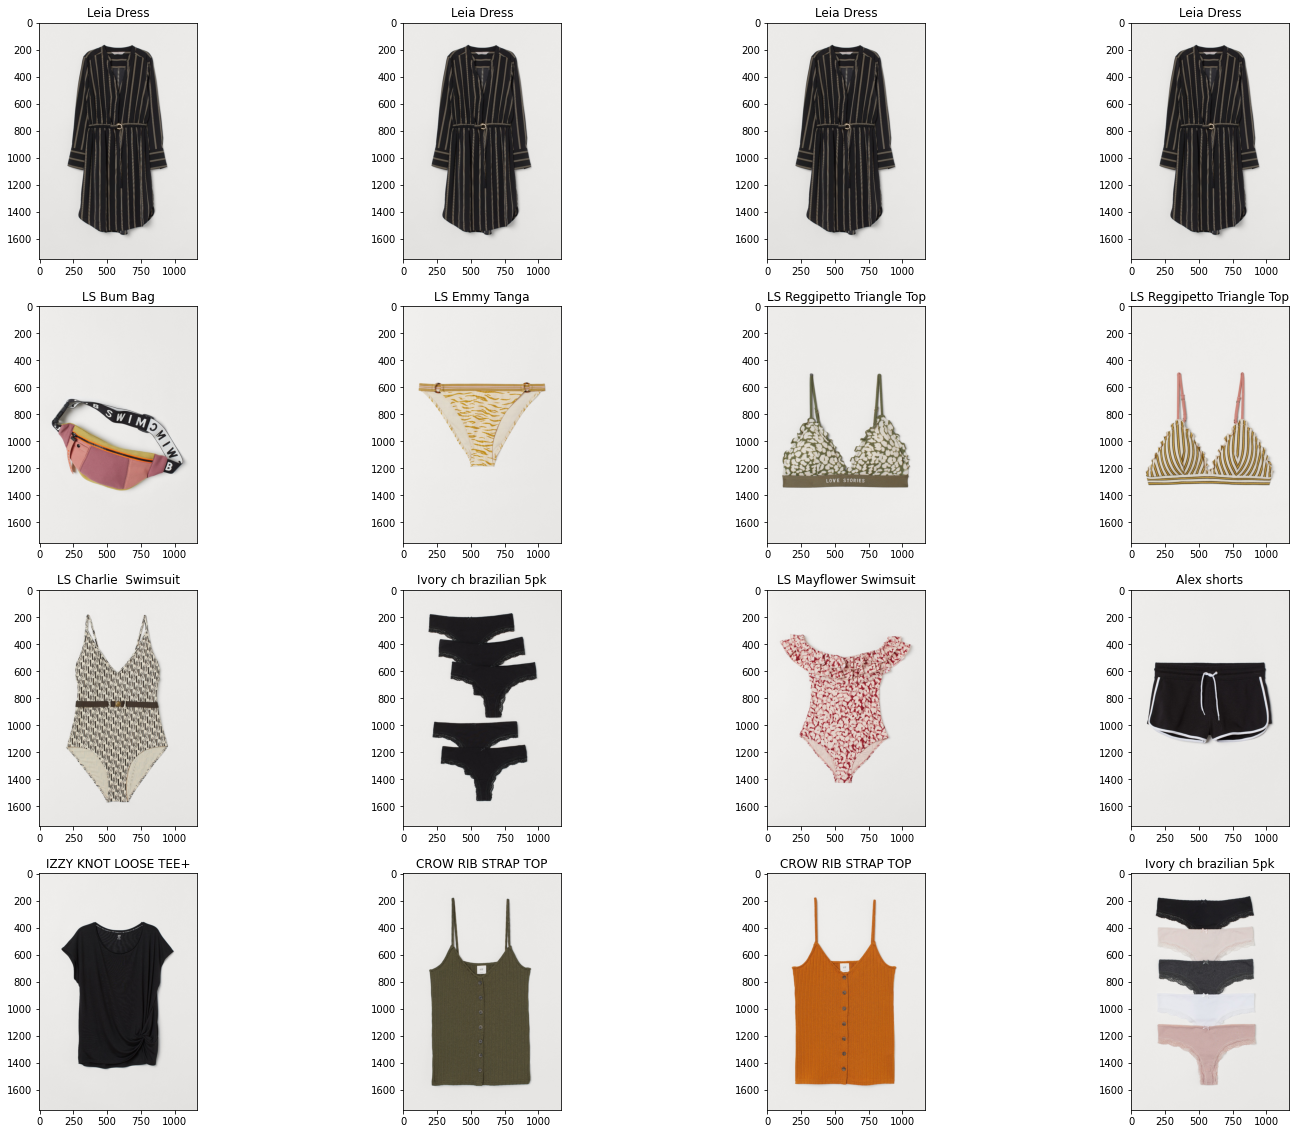

In [ ]:
# display results
fig, axs = plt.subplots(4, 4, figsize=(25, 20))
c = 0
for i in range(4):
    for j in range(4):
        ax = axs[i][j]
        if i == 0:
            ax.set_title(article_name)
            fname = '0' + str(article_id) + '.jpg'
            subdir = fname[0:3]
            full_path = os.path.join('data', 'images', subdir, fname)
        else:
            fname = '0' + str(similar_items[c]) + '.jpg'
            subdir = fname[0:3]
            full_path = os.path.join('data', 'images', subdir, fname)
            ax.set_title(item_names[similar_items[c]])
            c += 1
         
        if os.path.exists(full_path):
            img = mpimg.imread(full_path)
            ax.imshow(img)